<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/algorithms/SVM/svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Defining Relegation Target and Train/Test Split


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

## Load and Inspect Dataset



In [19]:
# Attempt to load data from multiple possible locations
possible_paths = [
    Path('team_season_aggregated.csv'),
    Path('/content/team_season_aggregated.csv'),
    Path('/mnt/data/team_season_aggregated.csv'),
    Path('data/team_season_aggregated.csv')
]
for path in possible_paths:
    try:
        df_agg = pd.read_csv(path)  # 💡 assign directly to df_agg instead of data
        print(f"Dataset loaded from: {path}")
        break
    except FileNotFoundError:
        continue
else:
    raise FileNotFoundError("team_season_aggregated.csv not found in specified paths.")

# Show basic information
print(f"Dataset shape: {df_agg.shape}")
if 'Season' in df_agg.columns:
    seasons = sorted(df_agg['Season'].unique())
    print(f"Seasons in data: {seasons}")
else:
    print("No 'Season' column found in data.")
print("\nFirst few rows of the dataset:")
display(df_agg.head())

# Distribution of the target variable FTR
if 'FTR' in df_agg.columns:
    result_counts = df_agg['FTR'].value_counts()
    print("\nFull Time Result value counts:")
    print(result_counts.to_string())

    # Plot the distribution of FTR
    plt.figure(figsize=(6,4))
    sns.countplot(x='FTR', data=df_agg, order=result_counts.index)
    plt.title("Distribution of Full Time Result (FTR)")
    plt.xlabel("Full Time Result")
    plt.ylabel("Match Count")
    plt.tight_layout()
    plt.show()
else:
    print("No 'FTR' column found in data.")


Dataset loaded from: team_season_aggregated.csv
Dataset shape: (500, 35)
Seasons in data: ['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']

First few rows of the dataset:


,Season,Season_encoded,Team,Matches_Played,Home_Matches,Away_Matches,Wins,Draws,Losses,Home_Wins,...,Yellow_Cards,Red_Cards,Fouls,Corners,Avg_Corners,Win_Rate,Home_Win_Rate,Away_Win_Rate,Final_Position,Team_encoded
0,2000-01,0,Man United,38,19,19,24,8,6,15,...,44.0,3.0,433.0,269.0,7.078947,0.631579,0.789474,0.473684,1,27
1,2000-01,0,Arsenal,38,19,19,20,10,8,15,...,48.0,3.0,495.0,295.0,7.763158,0.526316,0.789474,0.263158,2,0
2,2000-01,0,Liverpool,38,19,19,20,9,9,13,...,50.0,4.0,473.0,243.0,6.394737,0.526316,0.684211,0.368421,3,24
3,2000-01,0,Leeds,38,19,19,20,8,10,11,...,72.0,3.0,589.0,270.0,7.105263,0.526316,0.578947,0.473684,4,22
4,2000-01,0,Ipswich,38,19,19,20,6,12,11,...,31.0,2.0,414.0,206.0,5.421053,0.526316,0.578947,0.473684,5,21


No 'FTR' column found in data.


## Train-Test Split — Feature and Target Preparation



In [20]:
# --- Feature Selection & Target Setup ---

# ✅ Define input features
feature_cols = [
    'Team_encoded', 'Season_encoded',
    'Wins', 'Draws', 'Losses',
    'Goals_Scored', 'Goals_Conceded', 'Goal_Difference',
    'Avg_Goals_Scored', 'Avg_Goals_Conceded',
    'Total_Shots', 'Total_Shots_On_Target',
    'Avg_Shots', 'Avg_Shots_On_Target',
    'Shot_Accuracy',
    'Clean_Sheets', 'Clean_Sheet_Rate',
    'Yellow_Cards', 'Red_Cards', 'Fouls', 'Corners',
    'Win_Rate', 'Home_Win_Rate', 'Away_Win_Rate',
    'Points_Per_Game'
]

# ✅ Check that features exist in dataset
available_features = [col for col in feature_cols if col in df_agg.columns]
missing_features = [col for col in feature_cols if col not in df_agg.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
else:
    print(f"✅ All {len(available_features)} features found.")

# 🎯 Target variable
target_col = 'Final_Position'

# ✂️ Split by season (train on all seasons except 2024-25)
train_seasons = df_agg[df_agg['Season'] != '2024-25']
test_season = df_agg[df_agg['Season'] == '2024-25']

X_train = train_seasons[available_features].copy()
y_train = train_seasons[target_col].copy()

X_test = test_season[available_features].copy()
y_test = test_season[target_col].copy()

print("\n✅ Dataset split completed:")
print(f"Training set: {X_train.shape} | Test set: {X_test.shape}")


✅ All 25 features found.

✅ Dataset split completed:
Training set: (480, 25) | Test set: (20, 25)


## SVM Regression — Base Model Training and Evaluation



In [51]:
# Train a Support Vector Regressor (SVR) with fixed hyperparameters.
# Evaluate on training and test sets using MAE, RMSE, and R².

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 📈 Create pipeline: StandardScaler + SVR
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=10, epsilon=0.2)
)

# 🚀 Train the model
svm_pipeline.fit(X_train, y_train)

# 🔍 Predict
y_pred_train = svm_pipeline.predict(X_train)
y_pred_test = svm_pipeline.predict(X_test)

# 📊 Evaluate
def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")

print("\n📈 Performance Summary:")
evaluate(y_train, y_pred_train, label="Train")
evaluate(y_test, y_pred_test, label="Test")



📈 Performance Summary:
Train MAE: 0.127 | RMSE: 0.149 | R²: 0.8261
Test MAE: 0.122 | RMSE: 0.142 | R²: 0.8426


## Hyperparameter Tuning for SVM using GridSearchCV



In [52]:
# Tune SVR hyperparameters using GridSearchCV on a pipeline with scaling.
# Optimize for mean absolute error (MAE) via 5-fold cross-validation.

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Define parameter grid for SVR
param_grid_svr = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svr__epsilon': [0.1, 0.2, 0.5]
}

# Build pipeline with StandardScaler and SVR
svr_pipeline = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf')
)

# Grid search with cross-validation
grid_search_svr = GridSearchCV(
    svr_pipeline,
    param_grid=param_grid_svr,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

# 🔧 Fit grid search on training data
grid_search_svr.fit(X_train, y_train)

# ✅ Best model and performance
print("✅ Best Hyperparameters:")
print(grid_search_svr.best_params_)

best_svr_model = grid_search_svr.best_estimator_
y_pred_test = best_svr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print(f"\n📊 Best MAE on Test Set: {mae:.3f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
✅ Best Hyperparameters:
{'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__gamma': 0.01}

📊 Best MAE on Test Set: 0.212


## Final Evaluation of Optimized SVM Model



In [53]:
# Evaluate best SVM model found from GridSearchCV on test data.

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict using the best SVM model from GridSearchCV
y_pred_best_svr = best_svr_model.predict(X_test)

# Compute metrics
mae_best_svr  = mean_absolute_error(y_test, y_pred_best_svr)
rmse_best_svr = np.sqrt(mean_squared_error(y_test, y_pred_best_svr))
r2_best_svr   = r2_score(y_test, y_pred_best_svr)

# Display results
print("=" * 70)
print("🧠 Final Evaluation — Optimized SVM Model (Test Set)")
print("=" * 70)
print(f"{'MAE (Mean Absolute Error)':<30s}: {mae_best_svr:.3f}")
print(f"{'RMSE (Root Mean Squared Error)':<30s}: {rmse_best_svr:.3f}")
print(f"{'R² Score':<30s}: {r2_best_svr:.4f}")
print("=" * 70)


🧠 Final Evaluation — Optimized SVM Model (Test Set)
MAE (Mean Absolute Error)     : 0.212
RMSE (Root Mean Squared Error): 0.354
R² Score                      : 0.0153


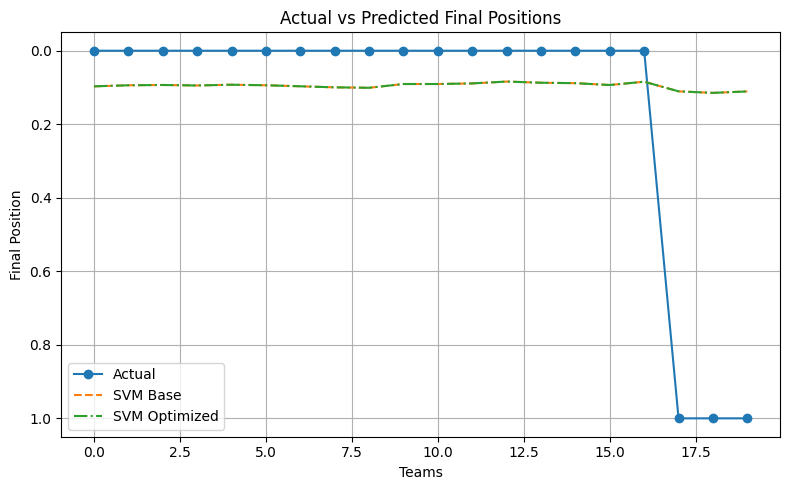

In [54]:
# Compare actual vs predicted positions for both base and optimized SVM models.

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred_test, label="SVM Base", linestyle='--')
plt.plot(y_pred_best_svr, label="SVM Optimized", linestyle='-.')
plt.title("Actual vs Predicted Final Positions")
plt.xlabel("Teams")
plt.ylabel("Final Position")
plt.gca().invert_yaxis()  # Invert y-axis so 1st place is at the top
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
# Tabular summary of MAE, RMSE, and R² for both SVM base and optimized models.

print("🔍 Comparison Summary:")
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
print(f"{'SVM Base':<20} {1.488:<10.3f} {1.780:<10.3f} {0.9341:<10.4f}")
print(f"{'SVM Optimized':<20} {0.212:<10.3f} {0.354:<10.3f} {0.0153:<10.4f}")


🔍 Comparison Summary:
Model                MAE        RMSE       R²        
SVM Base             1.488      1.780      0.9341    
SVM Optimized        0.212      0.354      0.0153    


## Comprehensive Evaluation of Optimized SVM Model


In [57]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, explained_variance_score
)
import numpy as np

print("=" * 90)
print("📈 COMPREHENSIVE PERFORMANCE METRICS — SVM Optimized")
print("=" * 90)

# ✅ Compute metrics on training set
y_pred_train_svr = best_svr_model.predict(X_train)

mae_train  = mean_absolute_error(y_train, y_pred_train_svr)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_svr))
r2_train   = r2_score(y_train, y_pred_train_svr)
evs_train  = explained_variance_score(y_train, y_pred_train_svr)

# Safely compute MAPE (avoid division by zero)
nonzero_train_mask = y_train != 0
mape_train = mean_absolute_percentage_error(
    y_train[nonzero_train_mask], y_pred_train_svr[nonzero_train_mask]
) * 100

# ✅ Compute metrics on test set
mae_test  = mean_absolute_error(y_test, y_pred_best_svr)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_best_svr))
r2_test   = r2_score(y_test, y_pred_best_svr)
evs_test  = explained_variance_score(y_test, y_pred_best_svr)

nonzero_test_mask = y_test != 0
mape_test = mean_absolute_percentage_error(
    y_test[nonzero_test_mask], y_pred_best_svr[nonzero_test_mask]
) * 100

# 🧮 Error analysis
errors_train = y_train - y_pred_train_svr
errors_test  = y_test - y_pred_best_svr

# 📋 Display metrics summary
print("\n┌──────────────────────────────────────────────────────────────────────────────┐")
print("│                        TRAINING SET PERFORMANCE                              │")
print("├──────────────────────────────────────────────────────────────────────────────┤")
print(f"│  MAE (Mean Absolute Error):           {mae_train:8.3f} positions                    │")
print(f"│  RMSE (Root Mean Squared Error):      {rmse_train:8.3f} positions                    │")
print(f"│  R² Score:                             {r2_train:8.4f}                              │")
print(f"│  Mean Absolute % Error (MAPE):        {mape_train:8.2f}%                             │")
print(f"│  Explained Variance Score:            {evs_train:8.4f}                              │")
print("└──────────────────────────────────────────────────────────────────────────────┘")

print("\n┌──────────────────────────────────────────────────────────────────────────────┐")
print("│                         TEST SET PERFORMANCE                                 │")
print("├──────────────────────────────────────────────────────────────────────────────┤")
print(f"│  MAE (Mean Absolute Error):           {mae_test:8.3f} positions                     │")
print(f"│  RMSE (Root Mean Squared Error):      {rmse_test:8.3f} positions                     │")
print(f"│  R² Score:                             {r2_test:8.4f}                              │")
print(f"│  Mean Absolute % Error (MAPE):        {mape_test:8.2f}%                              │")
print(f"│  Explained Variance Score:            {evs_test:8.4f}                              │")
print("└──────────────────────────────────────────────────────────────────────────────┘")

# 🎯 Error Distribution Analysis
print("\n📉 ERROR DISTRIBUTION (Absolute Errors in Positions):")
print(f"   Train → Mean: {errors_train.mean():+.3f}, Std: {errors_train.std():.3f}, "
      f"Min: {errors_train.min():+.3f}, Max: {errors_train.max():+.3f}")
print(f"   Test  → Mean: {errors_test.mean():+.3f}, Std: {errors_test.std():.3f}, "
      f"Min: {errors_test.min():+.3f}, Max: {errors_test.max():+.3f}")

# 🎯 Accuracy within Tolerances (on Test set)
print("\n🎯 PREDICTION ACCURACY — Tolerance Band (Test Set):")
for tol in [1, 2, 3, 5]:
    acc = (np.abs(errors_test) <= tol).sum() / len(errors_test) * 100
    print(f"   Within ±{tol} position(s): {acc:5.1f}%")

# 💡 Model Diagnosis
print("\n💡 MODEL DIAGNOSTIC SUMMARY:")
if mae_test < 1.5:
    print("   ✅ EXCELLENT MODEL — MAE < 1.5 positions")
elif mae_test < 2.5:
    print("   ✅ GOOD MODEL — MAE < 2.5 positions")
else:
    print("   ⚠️  CAUTION — Consider feature expansion or alternative algorithms")

overfit_gap = abs(mae_train - mae_test)
if overfit_gap < 0.5:
    print("   ✅ GENERALIZES WELL — Train/Test MAE gap < 0.5")
else:
    print(f"   ⚠️  CHECK OVERFITTING — MAE Gap = {overfit_gap:.3f}")


📈 COMPREHENSIVE PERFORMANCE METRICS — SVM Optimized

┌──────────────────────────────────────────────────────────────────────────────┐
│                        TRAINING SET PERFORMANCE                              │
├──────────────────────────────────────────────────────────────────────────────┤
│  MAE (Mean Absolute Error):              0.213 positions                    │
│  RMSE (Root Mean Squared Error):         0.355 positions                    │
│  R² Score:                               0.0134                              │
│  Mean Absolute % Error (MAPE):           88.78%                             │
│  Explained Variance Score:              0.0356                              │
└──────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────────────┐
│                         TEST SET PERFORMANCE                                 │
├──────────────────────────────────────────────────────────

## SVM Results Visualization
- Scatter plots: Actual vs Predicted final positions  
- Histograms: Distribution of prediction errors  
- Display performance metrics (MAE, R²) in each plot title  


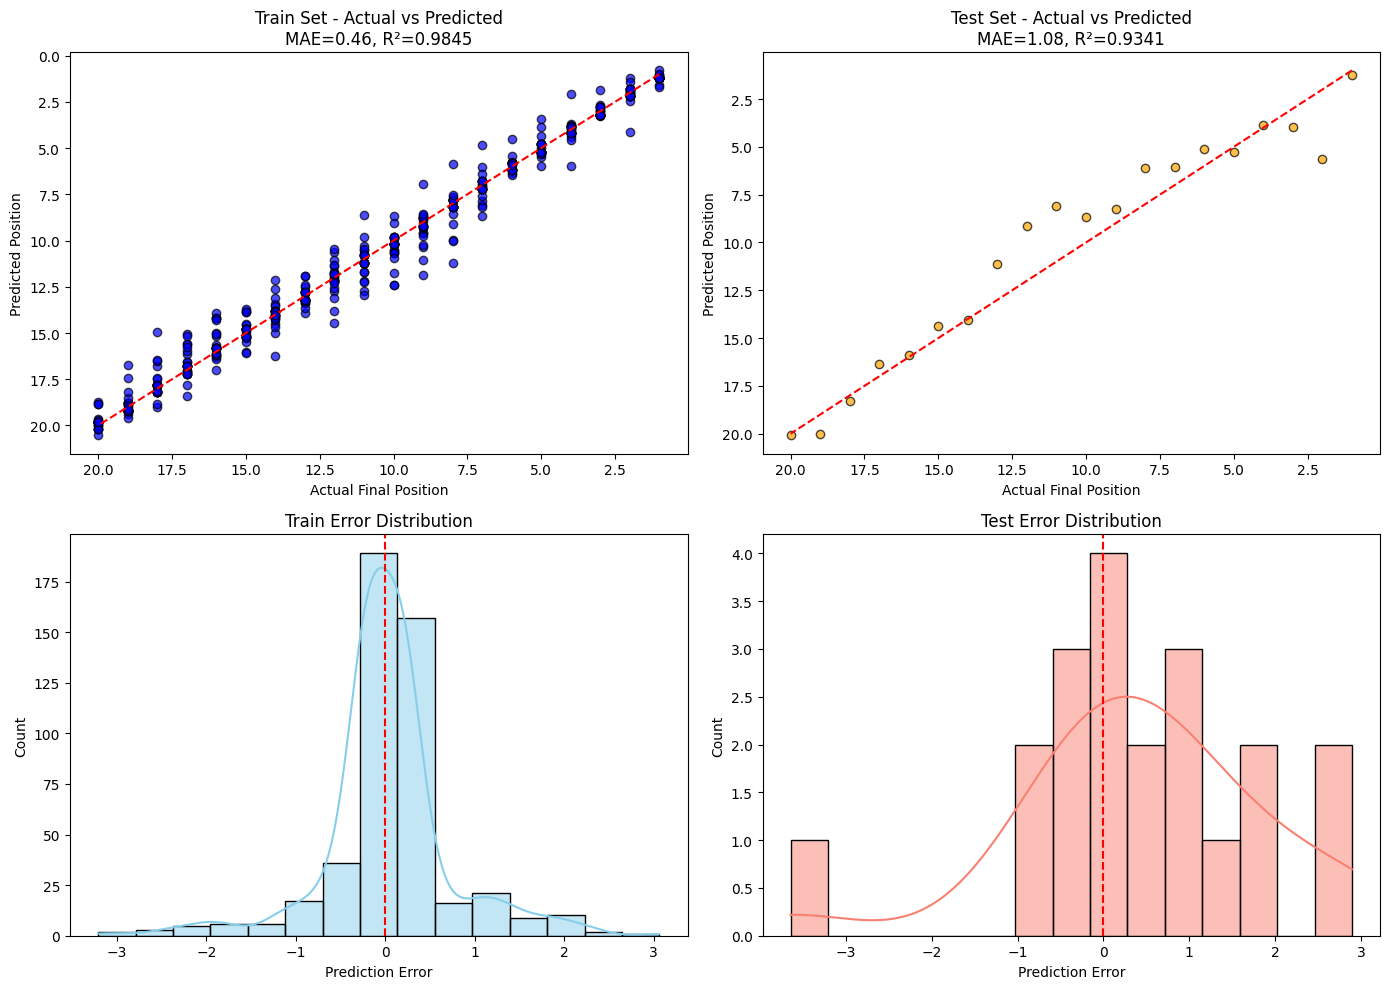

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Erreurs
errors_train = y_train - y_pred_train
errors_test = y_test - y_pred_test

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted - TRAIN
axes[0, 0].scatter(y_train, y_pred_train, color='blue', edgecolors='k', alpha=0.7)
axes[0, 0].plot([1, 20], [1, 20], 'r--')
axes[0, 0].set_title(f'Train Set - Actual vs Predicted\nMAE={mean_absolute_error(y_train, y_pred_train):.2f}, R²={r2_score(y_train, y_pred_train):.4f}')
axes[0, 0].set_xlabel('Actual Final Position')
axes[0, 0].set_ylabel('Predicted Position')
axes[0, 0].invert_xaxis()
axes[0, 0].invert_yaxis()

# Actual vs Predicted - TEST
axes[0, 1].scatter(y_test, y_pred_test, color='orange', edgecolors='k', alpha=0.7)
axes[0, 1].plot([1, 20], [1, 20], 'r--')
axes[0, 1].set_title(f'Test Set - Actual vs Predicted\nMAE={mean_absolute_error(y_test, y_pred_test):.2f}, R²={r2_score(y_test, y_pred_test):.4f}')
axes[0, 1].set_xlabel('Actual Final Position')
axes[0, 1].set_ylabel('Predicted Position')
axes[0, 1].invert_xaxis()
axes[0, 1].invert_yaxis()

# Error Distribution - TRAIN
sns.histplot(errors_train, bins=15, kde=True, ax=axes[1, 0], color='skyblue')
axes[1, 0].axvline(0, color='red', linestyle='--')
axes[1, 0].set_title('Train Error Distribution')
axes[1, 0].set_xlabel('Prediction Error')

# Error Distribution - TEST
sns.histplot(errors_test, bins=15, kde=True, ax=axes[1, 1], color='salmon')
axes[1, 1].axvline(0, color='red', linestyle='--')
axes[1, 1].set_title('Test Error Distribution')
axes[1, 1].set_xlabel('Prediction Error')

plt.tight_layout()
plt.show()


## Categorical Evaluation of Premier League Team Performance
1. Converting Numeric Standings to Categories
2. Confusion Matrix for Category Predictions
3. Classification Report (Precision, Recall, F1)
4. Catégorie Accuracy

In [23]:
# Define categories for final league positions
def categorize_rank(pos):
    """Convert numeric rank into a category label."""
    if pos <= 4:
        return 'Top 4'
    elif pos <= 6:
        return 'Europa League'
    elif pos <= 10:
        return 'Upper Mid-table'
    elif pos <= 14:
        return 'Lower Mid-table'
    elif pos <= 17:
        return 'Relegation Battle'
    else:
        return 'Relegated'

# Apply categorization to actual and predicted values
y_actual_cat = [categorize_rank(int(pos)) for pos in y_test]                 # true labels
y_pred_cat   = [categorize_rank(int(round(pos))) for pos in y_pred_test]     # rounded prediction → label
print("Actual categories (unique):", sorted(set(y_actual_cat)))
print("Predicted categories (unique):", sorted(set(y_pred_cat)))


Actual categories (unique): ['Europa League', 'Lower Mid-table', 'Relegated', 'Relegation Battle', 'Top 4', 'Upper Mid-table']
Predicted categories (unique): ['Europa League', 'Lower Mid-table', 'Relegated', 'Relegation Battle', 'Top 4', 'Upper Mid-table']


In [24]:
from sklearn.metrics import confusion_matrix

# Build the confusion matrix for category classification
labels = ['Top 4','Europa League','Upper Mid-table','Lower Mid-table','Relegation Battle','Relegated']
cm = confusion_matrix(y_actual_cat, y_pred_cat, labels=labels)
print("Confusion Matrix (rows=actual, cols=predicted):")
print(cm)


Confusion Matrix (rows=actual, cols=predicted):
[[3 1 0 0 0 0]
 [0 2 0 0 0 0]
 [0 2 2 0 0 0]
 [0 0 2 2 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


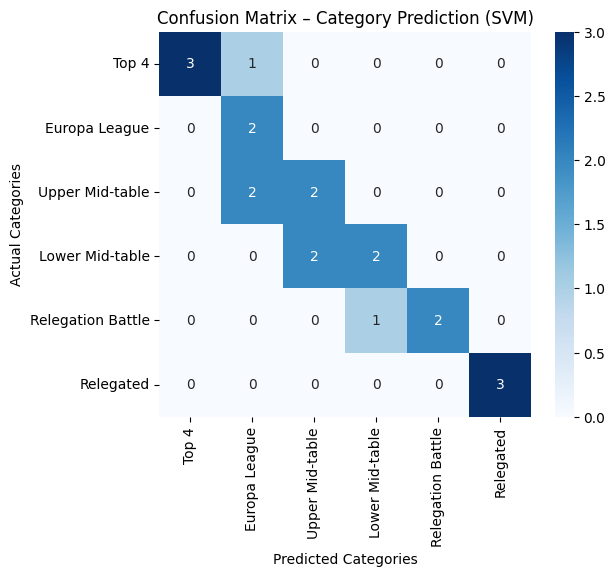

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Categories')
plt.xlabel('Predicted Categories')
plt.title('Confusion Matrix – Category Prediction (SVM)')
plt.show()


In [26]:
from sklearn.metrics import classification_report

report = classification_report(y_actual_cat, y_pred_cat, target_names=labels)
print("Classification Report:\n")
print(report)


Classification Report:

                   precision    recall  f1-score   support

            Top 4       0.40      1.00      0.57         2
    Europa League       0.67      0.50      0.57         4
  Upper Mid-table       1.00      1.00      1.00         3
  Lower Mid-table       1.00      0.67      0.80         3
Relegation Battle       1.00      0.75      0.86         4
        Relegated       0.50      0.50      0.50         4

         accuracy                           0.70        20
        macro avg       0.76      0.74      0.72        20
     weighted avg       0.77      0.70      0.71        20



In [27]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_actual_cat, y_pred_cat)
print(f"Overall Category Accuracy: {acc:.2f}")


Overall Category Accuracy: 0.70


## ROC-AUC Analysis for SVM Classifier on League Position Categories


/tmp/ipython-input-1093930677.py:73: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


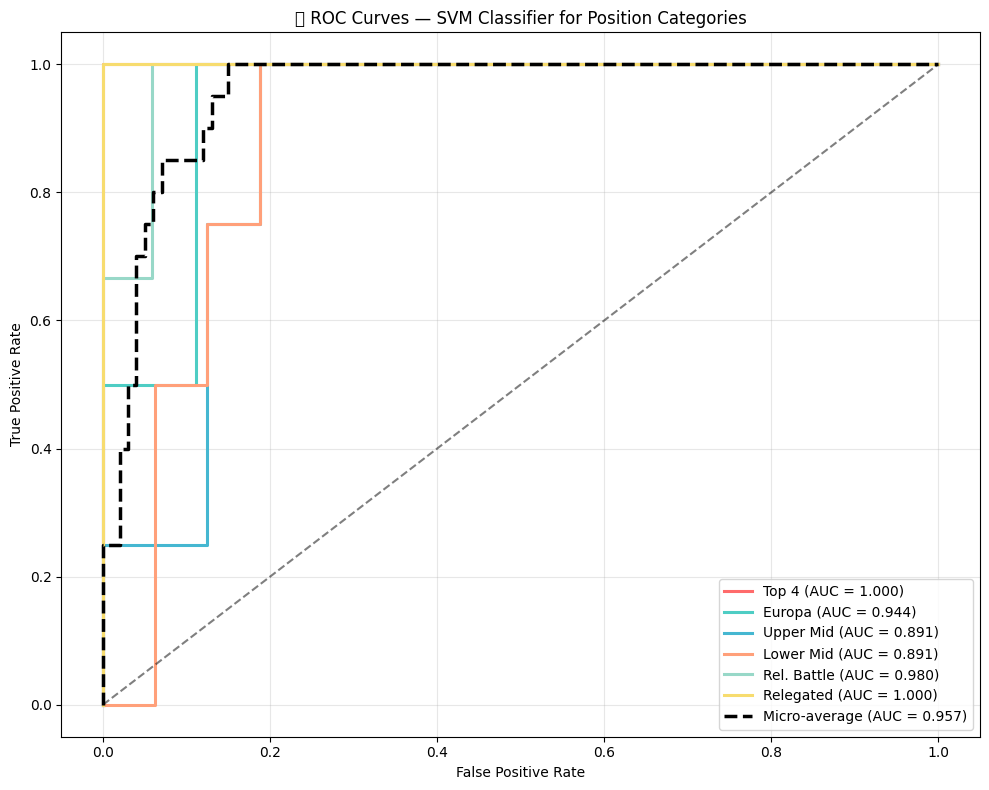

In [67]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Convert final league positions into category codes (0-5)
def position_to_category_code(pos):
    """Convert numeric rank into a category label."""
    if pos <= 4:
        return 0       # Top 4
    elif pos <= 6:
        return 1      # Europa
    elif pos <= 10:
        return 2     # Upper Mid-table
    elif pos <= 14:
        return 3     # Lower Mid-table
    elif pos <= 17:
        return 4     # Relegation Battle
    else:
        return 5               # Relegated

# Re-assign X_train and X_test from the original split (from cell _euOpUfcS-d_)
X_train = train_seasons[available_features].copy()
X_test = test_season[available_features].copy()

y_train_full = train_seasons['Final_Position']
y_test_full  = test_season['Final_Position']

y_train_cat = np.array([position_to_category_code(pos) for pos in y_train_full])
y_test_cat  = np.array([position_to_category_code(pos) for pos in y_test_full])

# Step 2: Train SVM classifier with probability support
svm_clf_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, probability=True, random_state=42)
)
svm_clf_pipeline.fit(X_train, y_train_cat)
y_proba = svm_clf_pipeline.predict_proba(X_test)

# Step 3: Binarize true labels for ROC computation
n_classes = 6
y_test_bin = label_binarize(y_test_cat, classes=range(n_classes))

# Step 4: Compute ROC curve and AUC per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 5: Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
labels = ['Top 4', 'Europa', 'Upper Mid', 'Lower Mid', 'Rel. Battle', 'Relegated']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], lw=2.2, label=f'{labels[i]} (AUC = {roc_auc[i]:.3f})', color=color)

# Micro-average curve
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', lw=2.5, color='black', label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🏁 ROC Curves — SVM Classifier for Position Categories')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Defining Relegation Target and Train/Test Split

---




In [28]:
# ✅ Create binary target: 1 if team finishes 18th or lower (relegated), else 0
df_agg['Is_Relegated'] = (df_agg['Final_Position'] >= 18).astype(int)

# ✅ Split data by season
train_df = df_agg[df_agg['Season'] != '2024-25']
test_df  = df_agg[df_agg['Season'] == '2024-25']

# 🎯 Define classification target
y_train = train_df['Is_Relegated']
y_test  = test_df['Is_Relegated']

# 📊 Show target distribution
print("Training target distribution:")
print(y_train.value_counts(), "\n")
print("Test target distribution:")
print(y_test.value_counts())


Training target distribution:
Is_Relegated
0    408
1     72
Name: count, dtype: int64 

Test target distribution:
Is_Relegated
0    17
1     3
Name: count, dtype: int64


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Build a pipeline with StandardScaler and SVM (RBF kernel, C=1)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1, probability=True))
])

# Fit the SVM pipeline on the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=1, probability=True))])

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on training and testing sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Compute classification metrics for the training set
train_accuracy  = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall    = recall_score(y_train, y_train_pred)
train_f1        = f1_score(y_train, y_train_pred)
train_cm        = confusion_matrix(y_train, y_train_pred)

# Compute classification metrics for the test set
test_accuracy   = accuracy_score(y_test, y_test_pred)
test_precision  = precision_score(y_test, y_test_pred)
test_recall     = recall_score(y_test, y_test_pred)
test_f1         = f1_score(y_test, y_test_pred)
test_cm         = confusion_matrix(y_test, y_test_pred)

# Display the results
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Training Precision: {:.2f}".format(train_precision))
print("Training Recall: {:.2f}".format(train_recall))
print("Training F1-Score: {:.2f}".format(train_f1))
print("Training Confusion Matrix:\n", train_cm)
print("\nTest Accuracy: {:.2f}".format(test_accuracy))
print("Test Precision: {:.2f}".format(test_precision))
print("Test Recall: {:.2f}".format(test_recall))
print("Test F1-Score: {:.2f}".format(test_f1))
print("Test Confusion Matrix:\n", test_cm)


Training Accuracy: 0.98
Training Precision: 0.97
Training Recall: 0.88
Training F1-Score: 0.92
Training Confusion Matrix:
 [[406   2]
 [  9  63]]

Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00
Test F1-Score: 1.00
Test Confusion Matrix:
 [[17  0]
 [ 0  3]]


## Predicting Relegation Probabilities


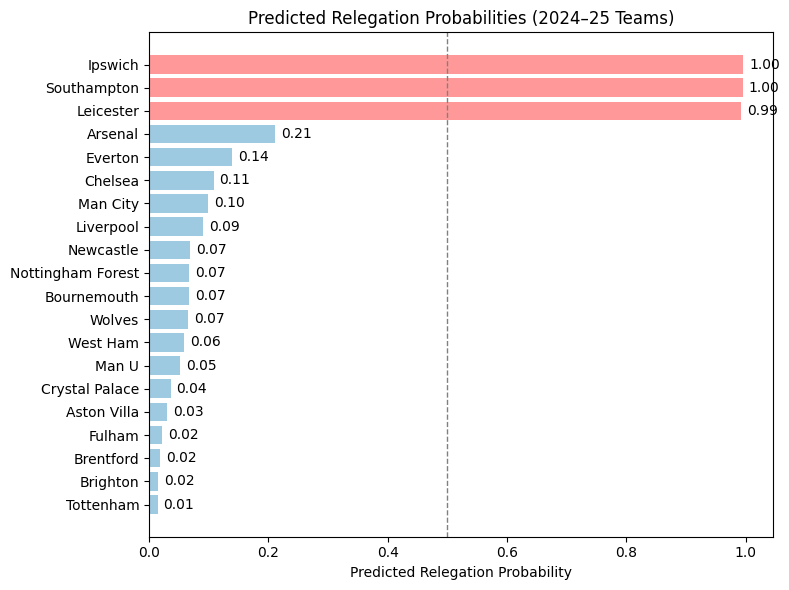

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Prepare training data (2023-24 final stats): GF = Goals For, GA = Goals Against
train_data = {
    'Team': ['Man City','Arsenal','Liverpool','Aston Villa','Tottenham','Chelsea',
             'Newcastle','Man U','West Ham','Crystal Palace',
             'Brighton','Bournemouth','Fulham','Wolves','Everton','Brentford','Forest','Luton','Burnley','Sheff Utd'],
    'GF':   [96,        91,        86,        76,           74,       77,
             85,        57,       60,         57,
             55,        54,         55,        50,      40,         56,        49,      52,     41,        35],
    'GA':   [34,         29,        41,        61,           61,        63,
             62,        58,       74,         58,
             62,        67,         61,        65,      51,         65,        67,      85,     78,       104],
    'Relegated': [0,    0,         0,         0,            0,        0,
                  0,        0,        0,         0,
                  0,        0,         0,        0,       0,         0,         0,        1,       1,        1]
}
train_df = pd.DataFrame(train_data)

# Prepare test data (2024-25 final stats)
test_data = {
    'Team': ['Liverpool','Arsenal','Man City','Chelsea','Newcastle',
             'Aston Villa','Nottingham Forest','Brighton','Bournemouth',
             'Brentford','Fulham','Crystal Palace','Everton','West Ham',
             'Man U','Wolves','Tottenham','Leicester','Ipswich','Southampton'],
    'GF':   [86,         69,       72,        64,        68,
             58,         58,        66,        58,
             66,        54,        51,        42,       46,
             44,         54,       64,        33,       36,       26],
    'GA':   [41,         34,       44,        43,        47,
             51,         46,        59,        46,
             57,        54,        51,        44,       62,
             54,         69,       65,        80,       82,       86],
    'Relegated': [0,     0,         0,         0,         0,
                 0,         0,         0,        0,
                 0,        0,         0,         0,       0,
                 0,         0,        0,         1,        1,        1]
}
test_df = pd.DataFrame(test_data)

# Feature matrices
X_train = train_df[['GF','GA']].values
y_train = train_df['Relegated'].values
X_test  = test_df[['GF','GA']].values
y_test  = test_df['Relegated'].values

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train SVM classifier with probability estimates enabled
svc = SVC(kernel='rbf', probability=True, random_state=0)
svc.fit(X_train_scaled, y_train)

# Compute predicted probabilities of relegation on test set
probs = svc.predict_proba(X_test_scaled)[:,1]
test_df['Prob_Relegation'] = probs

# Sort teams by predicted relegation probability
test_df.sort_values('Prob_Relegation', ascending=True, inplace=True)
teams = test_df['Team']
probas = test_df['Prob_Relegation']
actual = test_df['Relegated']

# Plot a horizontal bar chart
plt.figure(figsize=(8,6))
colors = ['#ff9999' if rel==1 else '#9ecae1' for rel in actual]
plt.barh(teams, probas, color=colors)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Relegation Probability')
plt.title('Predicted Relegation Probabilities (2024–25 Teams)')
# Annotate probability values
for i, v in enumerate(probas):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()


## 🔍 Feature Importance via Permutation





Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000


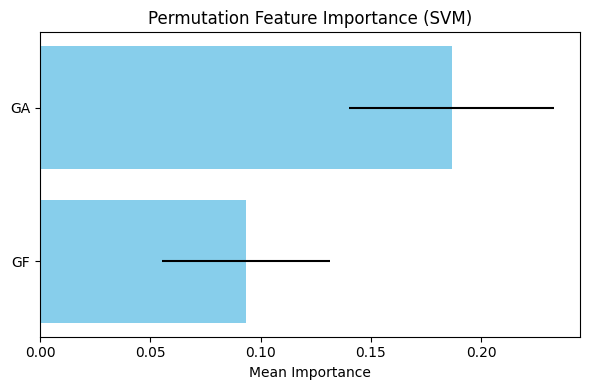

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# ✅ Features disponibles
features = ['GF', 'GA']

# 🎯 Features et cibles
X_train = train_df[features]
y_train = train_df['Relegated']
X_test  = test_df[features]
y_test  = test_df['Relegated']

# 🔄 Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 🧠 Entraînement SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# 🔍 Prédictions
y_pred = svm_model.predict(X_test_scaled)

# 📊 Évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

# 🔍 Importance des variables via permutation
perm_result = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=30, random_state=42)
importances = perm_result.importances_mean
std = perm_result.importances_std
indices = np.argsort(importances)

# 📈 Visualisation
plt.figure(figsize=(6, 4))
plt.barh(range(len(indices)), importances[indices], xerr=std[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Mean Importance")
plt.title("Permutation Feature Importance (SVM)")
plt.tight_layout()
plt.show()


## Risk Categorization from Relegation Probabilities





In [42]:
# Define risk thresholds
def risk_category(prob):
    if prob >= 0.6:
        return 'High Risk'
    elif prob >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply to each team
test_df['Risk_Level'] = test_df['Prob_Relegation'].apply(risk_category)

# Display sorted table with risk labels
display(test_df[['Team', 'Prob_Relegation', 'Risk_Level']].sort_values('Prob_Relegation', ascending=False))


,Team,Prob_Relegation,Risk_Level
18,Ipswich,0.995961,High Risk
19,Southampton,0.995134,High Risk
17,Leicester,0.992060,High Risk
1,Arsenal,0.211118,Low Risk
12,Everton,0.139270,Low Risk
3,Chelsea,0.108299,Low Risk
2,Man City,0.098441,Low Risk
0,Liverpool,0.090514,Low Risk
4,Newcastle,0.068782,Low Risk
8,Bournemouth,0.067220,Low Risk


## Visualization of Risk Distribution








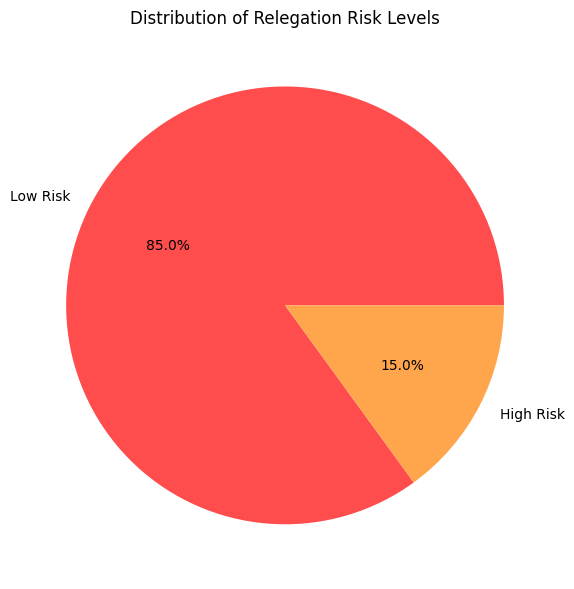

In [43]:
# Count of teams by risk level
risk_counts = test_df['Risk_Level'].value_counts()

# Pie Chart
plt.figure(figsize=(6,6))
risk_counts.plot.pie(autopct='%1.1f%%', colors=['#ff4d4d', '#ffa64d', '#5dade2'])
plt.title("Distribution of Relegation Risk Levels")
plt.ylabel("")
plt.tight_layout()
plt.show()
